# 1. Introduction

In this article we are going to analyze the Buenos Aires city bike system looking at it as a complex network. This abstraction allows to reduce the amount of information available and focus primarily on the internal structure of the underlying system. This is the second part of our series about `Buenos aires bike sharing system`, we encourage you to check out the first part in order to grasp easily what comes next.

The tool that we are using to carry out this analysis is [networkit library](https://networkit.github.io/index.html), which is an open-source toolkit for large-scale network analysis. Beside, we are using [kepler.gl](https://kepler.gl) to superimpose the nodes and edges on a map according to their position attributes (longitude and latitude).



In [1]:
import pandas as pd
import numpy as np
import json
import os

# Network analysis
import networkit as nk  


# Visualization
import matplotlib.pyplot as plt
from keplergl import KeplerGl


In [2]:
BLUE = (0.5529411764705883, 0.6274509803921569, 0.796078431372549)
PATH = "data/"

In [3]:
with open('bike_stations_encoded.json') as f:
    bike_station_en = json.load(f)

# 2. Load dataset


The data covers 449 stations and about 15 Millions trips that have occurred between 2019 and middle 2023 in the Buenos Aires city.

`bike_share_baires` has information about each ride from 2019 to 2023.

`bike_station_name` has information about station name.


In [4]:
df_bike_trip = pd.read_parquet(os.path.join(PATH, "bike_share_baires.parquet"), columns=['rout_id', 'duration', 'departure_station_id',
       'departure_long', 'departure_lat', 'return_station_id', 'return_station_long', 'return_station_lat', 'year'])

In [5]:
df_bike_trip['departure_station_id'] = df_bike_trip['departure_station_id'].map(bike_station_en)
df_bike_trip['return_station_id'] = df_bike_trip['return_station_id'].map(bike_station_en)

In [6]:
df_departure_station = pd.read_csv(os.path.join(PATH, "bike_station_name.csv"))
df_departure_station.columns = ['departure_station_id', 'departure_station_name']

In [7]:
df_bike_station = pd.read_csv(os.path.join(PATH, "bike_station_name.csv"))

In [8]:
df_return_station = pd.read_csv(os.path.join(PATH, "bike_station_name.csv"))
df_return_station.columns = ['return_station_id', 'return_station_name']

In [9]:
df_bike_trip = pd.merge(df_bike_trip, df_departure_station, on=['departure_station_id'], how='left')
df_bike_trip = pd.merge(df_bike_trip, df_return_station, on=['return_station_id'], how='left')

In [10]:
df_bike_trip = df_bike_trip[(df_bike_trip['departure_station_id']!=50) & (df_bike_trip['departure_station_id']!=53) & (df_bike_trip['return_station_id']!=50) & (df_bike_trip['return_station_id']!=53)]

In [11]:
df_bike_station_geo = df_bike_trip[['departure_station_id', 'departure_lat', 'departure_long']].drop_duplicates(['departure_station_id'])
df_bike_station_geo.columns = ['station_id', 'lat', 'long']

# 3.  Graph Object instance 

Here we define our Graphs which we are going to work with. Since the bike system has changed over the years we are going to build a network for each year.

In [12]:
def bikeGraph(dataframe, year=None, weight='count', directed=True):


    if year is None:
        df = df_bike_trip.copy()
    else: 
        df = df_bike_trip[df_bike_trip['year']==year].copy()


    # aggregating data
    # creating pairs
    # if 457 station, then we make a lot of pairs.
    origins = df['departure_station_id'].unique().tolist()
    destins = df['return_station_id'].unique().tolist()

    # creating pairs of trips
    pairs_list=[]
    for origin in origins:
        for destin in destins:
            stat_pair = (origin, destin)
            
            pairs_list.append(stat_pair)
    routes_list = list(range(len(pairs_list)))
    # dictionary with pairs and ID
    routes_dict = dict(zip(pairs_list, routes_list))

    # adding a columns with station pairs
    df['pairs'] = [(orID, deID) for orID, deID in zip(df['departure_station_id'].to_list(),
                                                                    df['return_station_id'].to_list())]

    df["path_id"] = df['pairs'].map(routes_dict)
    df["path_id"] = df["path_id"].astype("category")
    df = df.dropna()

    assert weight in ['count', 'duration'], f"'{weight}' not found in model dispatcher. Try with 'count' or 'duration'."

    if weight == 'count':
        df_agg = df.groupby("pairs").agg({"departure_station_id": "max",  "return_station_id": "max", "pairs": "count"
        })
    else :
        df_agg = df.groupby("pairs").agg({"departure_station_id": "max",  "return_station_id": "max", "duration": "mean"
        })


    df_agg.columns = ['departure_station_id', 'return_station_id', 'weight']

    
    # Graphs
    G = nk.graph.Graph(weighted=True, directed=directed)
    num_nodes = max(df_agg['departure_station_id'].max() ,df_agg['return_station_id'].max()) + 1
    for i in range(num_nodes):
        G.addNode()
    
    for idx, row in df_agg.iterrows():
        G.addEdge(row['departure_station_id'], row['return_station_id'], row['weight'])

    # remove isoloted nodes (fix problem with station id that change over year)
    for u in G.iterNodes():
        if G.isIsolated(u):
            G.removeNode(u)

    return G


In [13]:
G2019 = bikeGraph(df_bike_trip, 2019, weight='count')
print("Year: 2019")
print("Number of nodes: ", G2019.numberOfNodes(), " - Number of edges: ", G2019.numberOfEdges(), " - Number of self loops: ", G2019.numberOfSelfLoops())

Year: 2019
Number of nodes:  409  - Number of edges:  138660  - Number of self loops:  409


In [14]:
G2020 = bikeGraph(df_bike_trip, 2020, weight='count')
print("Year: 2020")
print("Number of nodes: ", G2020.numberOfNodes(), " - Number of edges: ", G2020.numberOfEdges(), " - Number of self loops: ", G2020.numberOfSelfLoops())

Year: 2020
Number of nodes:  398  - Number of edges:  94192  - Number of self loops:  398


In [15]:
G2021 = bikeGraph(df_bike_trip, 2021, weight='count')
print("Year: 2021")
print("Number of nodes: ", G2021.numberOfNodes(), " - Number of edges: ", G2021.numberOfEdges(), " - Number of self loops: ", G2021.numberOfSelfLoops())

Year: 2021
Number of nodes:  274  - Number of edges:  51106  - Number of self loops:  274


In [16]:
G2022 = bikeGraph(df_bike_trip, 2022, weight='count')
print("Year: 2022")
print("Number of nodes: ", G2022.numberOfNodes(), " - Number of edges: ", G2022.numberOfEdges(), " - Number of self loops: ", G2022.numberOfSelfLoops())

Year: 2022
Number of nodes:  329  - Number of edges:  68813  - Number of self loops:  328


In [17]:
G2023 = bikeGraph(df_bike_trip, 2023, weight='count')
print("Year: 2023")
print("Number of nodes: ", G2023.numberOfNodes(), " - Number of edges: ", G2023.numberOfEdges(), " - Number of self loops: ", G2023.numberOfSelfLoops())

Year: 2023
Number of nodes:  321  - Number of edges:  54069  - Number of self loops:  320


We can see that some changes are obvios in respecto to the number of nodes and edges over the years. In 2019 we observe the most number of vertices and edges and also how it has reduced in the last years as seen before in the previous analysis.

Most of the nodes have a self loop, because most trips start and end in the same station. 

# 4. Centrality Measure


## 4.1. Degree centrality
Node degree or the number of edges connected to a node, is one of the most studied properties of the network. Types of networks are often characterized in terms of their distribution of node degrees. 

${C}_{D}(i) =  {\sum \limits _{i=1} ^{N} x_{ij}  }_{{i}\ne{j}} $

A node with a high degree is a node to be expected to be central or popular in the network. 
In this context, the `degree` of a bike station refers to the number of bike stations that users have travelled from it to the target station.
We obtain and visualize the degree distribution of our example network as follows.

In [18]:
def centralityDegreeDist(G):
    """
    Centrality degree distribution
    """
    # Degree
    dd = sorted(nk.centrality.DegreeCentrality(G).run().scores(), reverse=True)
    deg, cnt = np.unique(dd, return_counts=True)

    # Figure
    fig, ax = plt.subplots(figsize=(10,5))
    plt.bar(deg[1:], cnt[1:], width=1, color=BLUE)
    #plt.axvline(x = np.median(deg), color="blue", linestyle='-', linewidth=1) # Degree Median

    # Labeling
    plt.title("Buenos Aires City Bike Network Degree Distribution")
    plt.ylabel("Number of nodes")
    plt.xlabel("Degree")

   

    plt.show()

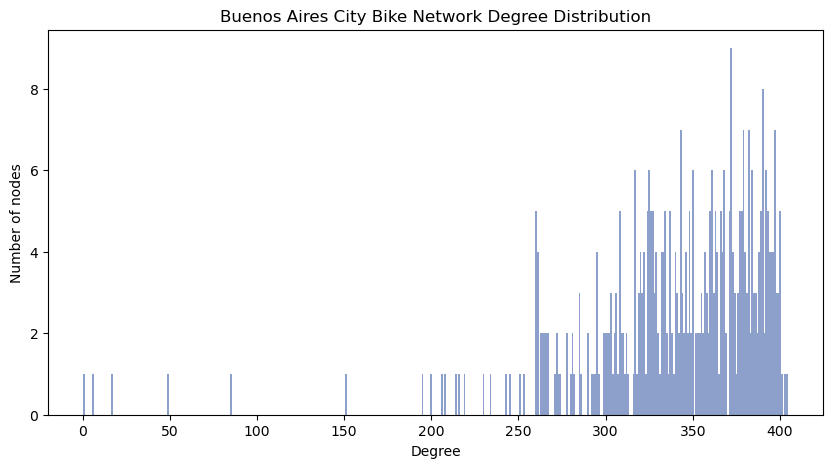

In [19]:
centralityDegreeDist(G2019)

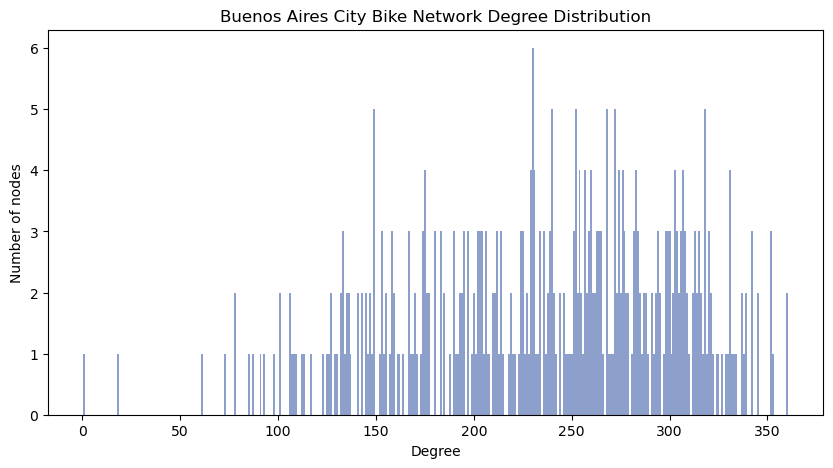

In [20]:
centralityDegreeDist(G2020)

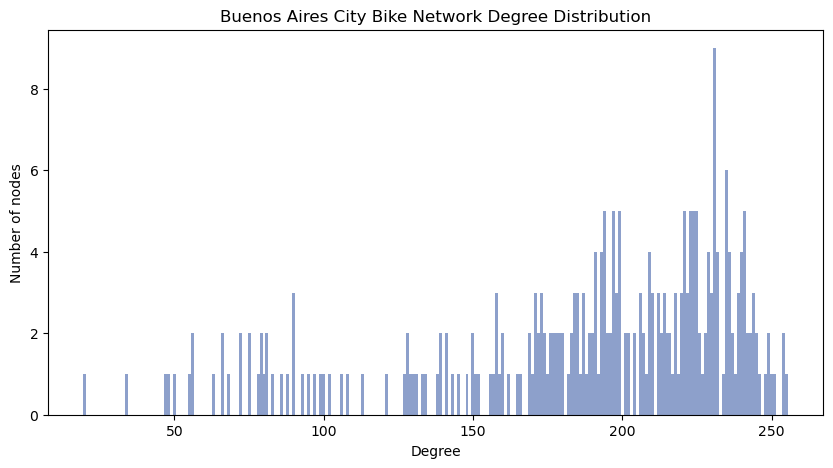

In [21]:
centralityDegreeDist(G2021)

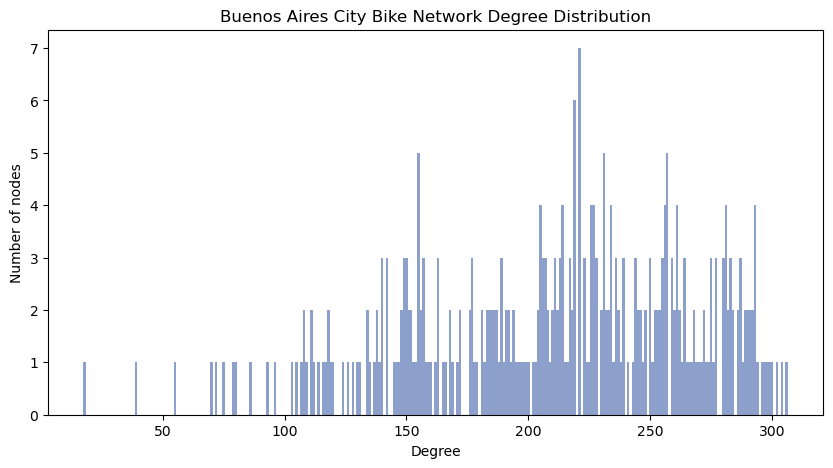

In [22]:
centralityDegreeDist(G2022)

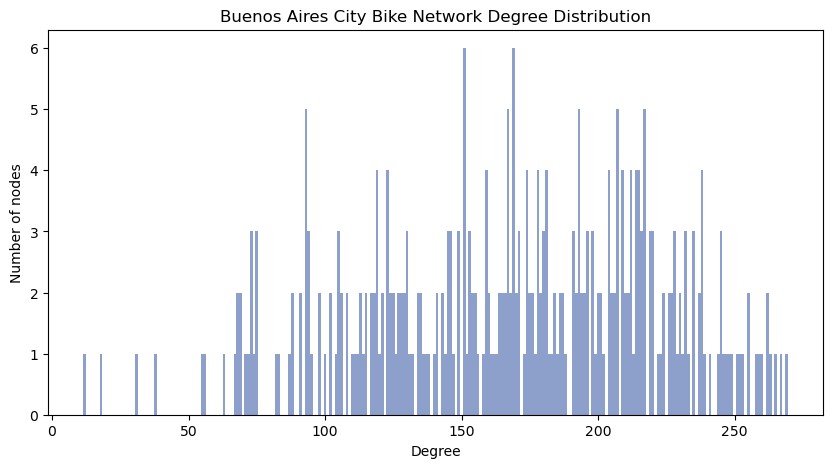

In [23]:
centralityDegreeDist(G2023)

As you can se above. Centrality degree distribution has changed over the year:

- In 2019 we find a major number of nodes with high number of degree within the center, and most are concentrated between 250 and 400. The distribution is left-skewed and the average degree is 339.

- In 2020 and 2021 we can see that degrees centrality decreased due to the consequences of lockdown during COVID-19 pandemic.
- In 2022 there was a slight recovered regarding degree centrality in comparison to previous year.
- In 2023 the degree distribution is more likely a normal distribution and the average degree is 168. We can see the overall degree centrality is lower than the privous year, but it is because at the moment we don't have the compleate information for this year.

The stations with the highest centrality degree are:

In [22]:
# Degree
dd = sorted(nk.centrality.DegreeCentrality(G2019).run().scores(), reverse=True)
deg, cnt = np.unique(dd, return_counts=True)

In [24]:
df_station_degree = pd.DataFrame([(u, G2019.degree(u)) for u in G2019.iterNodes()], columns=['station_id', 'degree'])
df_station_degree = pd.merge(df_station_degree, df_bike_station, on=['station_id'], how='inner').sort_values('degree', ascending=False)
print(df_station_degree.head(10))
print("mean degree 2019: ", df_station_degree.degree.mean())

     station_id  degree                  station_name
9             9     405       029 - Parque Centenario
30           30     404                014 - Pacifico
28           28     402       054 - Acuña de Figueroa
143         145     401  134 - SOLDADO DE LA FRONTERA
91           93     401               161 - Humahuaca
94           96     401                 171 - Pasteur
7             7     401            025 - Plaza Guemes
41           41     401        104 - Federico Lacroze
0             0     400            005 - Plaza Italia
97           99     400                 136 - Acevedo
mean degree 2019:  339.02200488997556


In [26]:
df_station_degree = pd.DataFrame([(u, G2022.degree(u)) for u in G2022.iterNodes()], columns=['station_id', 'degree'])
df_station_degree = pd.merge(df_station_degree, df_bike_station, on=['station_id'], how='inner').sort_values('degree', ascending=False)
print(df_station_degree.head(10))
print("mean degree 2022: ", df_station_degree.degree.mean())

     station_id  degree             station_name
29           30     307           014 - Pacifico
89           99     305            136 - Acevedo
27           28     303  054 - Acuña de Figueroa
104         120     301      276 - PRIMERA JUNTA
9             9     300  029 - Parque Centenario
36           37     299      017 - Plaza Almagro
83           93     298          161 - Humahuaca
32           33     297      096 - Carlos Gardel
0             0     295       005 - Plaza Italia
248         342     294   100 - Plaza Gurruchaga
mean degree 2022:  209.1580547112462


In [27]:
df_station_degree = pd.DataFrame([(u, G2023.degree(u)) for u in G2023.iterNodes()], columns=['station_id', 'degree'])
df_station_degree = pd.merge(df_station_degree, df_bike_station, on=['station_id'], how='inner').sort_values('degree', ascending=False)
print(df_station_degree.head(10))
print("mean degree 2023: ", df_station_degree.degree.mean())

     station_id  degree                 station_name
29           30     270               014 - Pacifico
27           28     268      054 - Acuña de Figueroa
86           99     266                136 - Acevedo
0             0     264           005 - Plaza Italia
80           93     263              161 - Humahuaca
9             9     263      029 - Parque Centenario
315         443     261                142 - ARMENIA
161         212     260  255 - BARRANCAS DE BELGRANO
35           37     259          017 - Plaza Almagro
117         146     256                  121 - YATAY
mean degree 2023:  168.4392523364486


In [28]:
df_station_degree = pd.merge(df_station_degree, df_bike_station_geo, on=['station_id'], how='inner')


From now on we are only going to focus in the 2023 network. Lets see on the map the station degree of each bike station in 2023

As we can see in the graph below stations located in Buenos Aires center have the highest number of connections. As we move to the west and south of the city the degree of the nodes gradually decreases.

In [30]:
with open( "config/station_degree_confmap.json") as f:
    config_map = json.load(f)
    
map_bike_trips = KeplerGl(height=600,  data={"Station Degree": df_station_degree}, config=config_map)
map_bike_trips

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'wbmbn57', 'type': …

The stations `014 - Pacifico`,  `054 - Acuña de Figueroa`, `136 - Acevedo` and `005 - Plaza Italia` are at the top of this list suggesting that a large number of citizens from different districts make regular trips to and from this station. They are either next to a large transportation hub or an important point of interest such as large educational institution and hospitals points.

Now, lets calculate the degree In and Out of the stations, that will allow us to know which stations might require more replenishments or docks to support their supply and demand. By computing the degree of each vertex based on their incoming and outgoing edges, we are able to determine their ratio.


### 4.1.1. Degree In: incoming/outgoing

A high in-out degree means that there are a lot more bikes parking here than going out, indicating a high supply of bikes. In other words, there may be a lack of docks. High in-out ratios occur in bike stations like `014 - Pacifico`  which is near to Palermo railway and subway station (One of the hotspot of Buenos aires city) and `014 - Pacifico` close to Centenario Park and Angel Gallardo Subway station that is a halfway spot to this subway.

From this simple analysis, it seems to be good for business in considerin the placement of more docks near these stations so that other users would not face the issue of not having enough docks to return the bikes. Let's lock them on the map to have a better understanding.

Note: green path means incoming, whereas red means outgoing.

In [35]:
df_bike_trip_agg = df_bike_trip[df_bike_trip['year']==2023].groupby(['departure_station_id', 'return_station_id'])\
                                .agg({'departure_long':'min', 'departure_lat':'min', 'return_station_long':'min', 'return_station_lat':'min', 'rout_id': 'count'})\
                                .reset_index()

df_bike_trip_agg = df_bike_trip_agg.dropna()

df_bike_trip_agg = df_bike_trip_agg[df_bike_trip_agg['departure_station_id']!=df_bike_trip_agg['return_station_id'] ]

df_station_degree_in = pd.DataFrame([(u, G2023.degreeIn(u)) for u in G2023.iterNodes()], columns=['station_id', 'degree_in'])
df_station_degree_in = pd.merge(df_station_degree_in, df_bike_station, on=['station_id'], how='inner').sort_values('degree_in', ascending=False)


In [36]:
df_station_degree_in = pd.merge(df_station_degree_in, df_bike_station_geo, on=['station_id'], how='inner')
df_station_degree_in = pd.merge(df_bike_trip_agg, df_station_degree_in.iloc[:20,:] , left_on='return_station_id' , right_on='station_id', how='inner')

with open( "config/station_degree_in_confmap.json") as f:
    config_map = json.load(f)
    
map_bike_trips = KeplerGl(height=600,  data={"Station Degree": df_station_degree_in}, config=config_map)
map_bike_trips

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'jtlqnai', 'type': …

### 4.1.2. Degree Out: outgoing/incoming
A high out-in value means that there are a lot more bikes leaving here which could result in a shortage, indicating high demand for bikes. In other words, there may be a lack of bikes.

The highest out-in ratio belongs to `014 - Pacifico` that is on Santa Fe Av., close to Palermo rail and subway station. As we have seen before, this station is also the thirth with highest Degree In ratio, this means that maybe, there is a balance between outgoing and incoming bikes.


005 - Plaza Italia is one of the most outgoing bike station and it because is close to many important spot like Italia subway station, Italian Park and La Rural. This is a station to be wary of as there could be a shortage of bikes. 
It interesting to note that these station are mostly run off of bicycles and most of the time it is hard to get one. So it needs a biger supply of bikes to these stations.



In [37]:
df_station_degree_out = pd.DataFrame([(u, G2023.degreeOut(u)) for u in G2023.iterNodes()], columns=['station_id', 'degree_out'])
df_station_degree_out = pd.merge(df_station_degree_out, df_bike_station, on=['station_id'], how='inner').sort_values('degree_out', ascending=False)
df_station_degree_out = pd.merge(df_station_degree_out, df_bike_station_geo, on=['station_id'], how='inner')
df_station_degree_out = pd.merge(df_bike_trip_agg, df_station_degree_out.iloc[:20,:] , left_on='departure_station_id' , right_on='station_id', how='inner')


with open( "config/station_degree_out_confmap.json") as f:
    config_map = json.load(f)
    
map_bike_trips = KeplerGl(height=600,  data={"Station Degree": df_station_degree_out}, config=config_map)
map_bike_trips

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'jtlqnai', 'type': …

## 4.2. Betweenness Centrality

The betweenness centrality is a measure of how often a node is a bridge between other nodes. It measures how frequently a node falls on the middle or on the shortest paht between different nodes in the network. Nodes with high between centrality are often important controllers of power or information
Most of the time they are boundary spanner between tow clusters in a network.

For every pair of vertices in a connected graph, there exists at least one shortest path between the vertices such that either the number of edges that the path passes through (for unweighted graphs) or the sum of the weights of the edges (for weighted graphs) is minimized. The betweenness centrality for each vertex is the number of these shortest paths that pass through the vertex.

$ Betweenness Centrality (C_B) = \frac{{\sum_{s \neq v \neq t} \frac{{\sigma_{st}(v)}}{{\sigma_{st}}}}}{\binom{n}{2}} $


In a weighted network the links connecting the nodes are no longer treated as binary interactions, but are weighted in proportion to their capacity, influence, frequency, etc., which adds another dimension of heterogeneity within the network beyond the topological effects. A node’s strength in a weighted network is given by the sum of the weights of its adjacent edges.


The graph below illustrates the city bike stations by betweenness centrality.

In [38]:
G2019.removeSelfLoops()
G2020.removeSelfLoops()
G2021.removeSelfLoops()
G2022.removeSelfLoops()
G2023.removeSelfLoops()

In [40]:
bc = nk.centrality.Betweenness(G2023)
bc.run()
df_betweeness_cent = pd.DataFrame(bc.ranking(), columns=['station_id', 'betweeness_centrality'])

df_betweeness_cent = pd.merge(df_betweeness_cent, df_bike_station, on=['station_id'], how='inner').sort_values('betweeness_centrality', ascending=False)
df_betweeness_cent = pd.merge(df_betweeness_cent, df_bike_station_geo, on=['station_id'], how='inner')

df_betweeness_cent = df_betweeness_cent.iloc[:20,:]
station_ids = df_betweeness_cent.station_id.unique().tolist()

df_bike_trip_agg = df_bike_trip_agg[df_bike_trip_agg['departure_station_id'].isin(station_ids) | df_bike_trip_agg['return_station_id'].isin(station_ids)]

with open( "config/station_betweenness_cent_confmap.json") as f:
    config_map = json.load(f)
    
map_bike_trips = KeplerGl(height=600,  data={"Betweenness Centrality": df_betweeness_cent, "Bike trips": df_bike_trip_agg}, config=config_map)
map_bike_trips

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'vh6j7v6', 'type': …

The nodes with the highest “betweenness centrality” are `Plaza de la Misericordia`, `Plaza 24 de Septiembre` and `Carabobo` bike station. As we can see from the graph above, most of this nodes are located in the middle of the city where they serve as a halfway between bikes station in the city center and those that are in the west. 

We might think that due to the demografic distribution of the city, traffic flows from the hotest point to other nodes which are mostly channelled through these station, but in reality, its hardly  happens that riders use these stations as a halfway point. Even Though, it might be a good idea to place more docks in these bike stations.



## 4.3. Closeness Centrality

Closeness centrality measures how close a node is to all other nodes in the network. It is based on the average shortest path distance from the node to all other nodes. Nodes with higher closeness centrality are more central in the sense that they can reach other nodes more quickly.

$ Closeness Centrality (C_C) = \frac{{n - 1}}{{\sum_{v \neq s} d(s, v)}} $


In [41]:
df_bike_trip_agg = df_bike_trip[df_bike_trip['year']==2023].groupby(['departure_station_id', 'return_station_id'])\
                                .agg({'departure_long':'min', 'departure_lat':'min', 'return_station_long':'min', 'return_station_lat':'min', 'rout_id': 'count'})\
                                .reset_index()

df_bike_trip_agg = df_bike_trip_agg.dropna()

df_bike_trip_agg = df_bike_trip_agg[df_bike_trip_agg['departure_station_id']!=df_bike_trip_agg['return_station_id'] ]


# Initialize algorithm
close = nk.centrality.Closeness(G2023, False, nk.centrality.ClosenessVariant.Generalized)
close.run()

#The most central nodes according to betweenness are then 
df_closeness_cent = pd.DataFrame(close.ranking(), columns=['station_id', 'closeness_centrality'])

df_closeness_cent = pd.merge(df_closeness_cent, df_bike_station, on=['station_id'], how='inner').sort_values('closeness_centrality', ascending=False)
df_closeness_cent = pd.merge(df_closeness_cent, df_bike_station_geo, on=['station_id'], how='inner')

df_closeness_cent = df_closeness_cent.iloc[:20,:]
station_ids = df_closeness_cent.station_id.unique().tolist()

df_bike_trip_agg = df_bike_trip_agg[df_bike_trip_agg['departure_station_id'].isin(station_ids) | df_bike_trip_agg['return_station_id'].isin(station_ids)]

with open( "config/station_closeness_cent_confmap.json") as f:
    config_map = json.load(f)
    
map_bike_trips = KeplerGl(height=600,  data={"Closeness Centrality": df_closeness_cent, "Bike trips": df_bike_trip_agg}, config=config_map)
map_bike_trips

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '493mhh8', 'type': …

## 4.4. Eigenvector Centrality 

Eigenvector centrality assign relative importance to nodes according to their connections, incorporating the idea that edges to high-scoring nodes contribute more.Nodes with high Eigenvector Centrality have connections to other nodes with high centrality, contributing to their own centrality. It takes into account both the number of connections a node has and the centrality of those connected nodes.

$ Eigenvector Centrality (C_E) = \frac{1}{\lambda} \cdot A \cdot C_E $


​	
* $(C_E)$ represents the Eigenvector Centrality vector for all nodes in the graph.
* $ A $ is the adjacency matrix of the graph.
* $ \lambda $ is the dominant eigenvalue of the adjacency matrix $ A $


In [42]:
df_bike_trip_agg = df_bike_trip[df_bike_trip['year']==2023].groupby(['departure_station_id', 'return_station_id'])\
                                .agg({'departure_long':'min', 'departure_lat':'min', 'return_station_long':'min', 'return_station_lat':'min', 'rout_id': 'count'})\
                                .reset_index()

df_bike_trip_agg = df_bike_trip_agg.dropna()

df_bike_trip_agg = df_bike_trip_agg[df_bike_trip_agg['departure_station_id']!=df_bike_trip_agg['return_station_id'] ]


# Eigenvector centrality
ec = nk.centrality.EigenvectorCentrality(G2023)
ec.run()

df_eigenvector_cent = pd.DataFrame(ec.ranking(), columns=['station_id', 'eigenvector_centrality'])

df_eigenvector_cent = pd.merge(df_eigenvector_cent, df_bike_station, on=['station_id'], how='inner').sort_values('eigenvector_centrality', ascending=False)
df_eigenvector_cent = pd.merge(df_eigenvector_cent, df_bike_station_geo, on=['station_id'], how='inner')

df_eigenvector_cent = df_eigenvector_cent.iloc[:20,:]
station_ids = df_eigenvector_cent.station_id.unique().tolist()

df_bike_trip_agg = df_bike_trip_agg[df_bike_trip_agg['departure_station_id'].isin(station_ids) | df_bike_trip_agg['return_station_id'].isin(station_ids)]

with open( "config/station_eigenvector_cent_confmap.json") as f:
    config_map = json.load(f)
    
map_bike_trips = KeplerGl(height=600,  data={"Eigenvector Centrality": df_eigenvector_cent, "Bike trips": df_bike_trip_agg}, config=config_map)
map_bike_trips


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'dh9bh5', 'type': '…

In [68]:
# PageRank
pr = nk.centrality.PageRank(G2023, 1e-6)
pr.run()

df_pagerank_cent = pd.DataFrame(pr.ranking(), columns=['station_id', 'pagerank_centrality'])

df_pagerank_cent = pd.merge(df_pagerank_cent, df_bike_station, on=['station_id'], how='inner').sort_values('pagerank_centrality', ascending=False)
df_pagerank_cent.head(10)

,station_id,pagerank_centrality,station_name
0,12,0.003115,147 - Constitución
1,30,0.003115,014 - Pacifico
2,226,0.003115,281 - Villa Urquiza
3,212,0.003115,255 - BARRANCAS DE BELGRANO
4,399,0.003115,352 - San Jose de Flores
5,17,0.003115,008 - Congreso
6,0,0.003115,005 - Plaza Italia
7,353,0.003115,207 - PLAZA ARENALES
8,337,0.003115,396 - PLAZA ALBERTI
9,100,0.003115,128 - PARQUE DEL BAJO


## 5. Community Detection

Community detection is often used to understand the structure of complex networks and identify groups of nodes which are significantly more densely connected to eachother than to the rest of the network. These algorithms can help us to better understand bike usege patterns and might determine adequate pricing models or better docks arragement.
There is a number of algorithms available for community detection but in this case we have focused only on the `Louvain Method` due to its beautiful simplicity and computational efficiency. Applying the Louvain method to the Buenos Aires city bike network reveals five distinct clusters.

In [19]:
# In order to apply this algorithm we have to turn the graph to undirected type.
G2023 = bikeGraph(df_bike_trip, 2023, weight='count', directed=False)
print("Year: 2023")
print("Number of nodes: ", G2023.numberOfNodes(), " - Number of edges: ", G2023.numberOfEdges(), " - Number of self loops: ", G2023.numberOfSelfLoops())

Year: 2023
Number of nodes:  321  - Number of edges:  54069  - Number of self loops:  320


In [20]:
# Choose and initialize algorithm
# This help to find the optimum number of communities
plmCommunities = nk.community.detectCommunities(G2023, algo=nk.community.PLM(G2023, True))

Communities detected in 0.01554 [s]
solution properties:
-------------------  -------------
# communities             5
min community size       15
max community size       89
avg. community size      64.2
imbalance                 1.36923
edge cut             278607
edge cut (portion)        5.1528
modularity                0.447088
-------------------  -------------


/Users/galissa/miniconda3/envs/graph/lib/python3.8/site-packages/networkit/stopwatch.py:49: UserWarning: networkit.Timer is deprecated, will be removed in future updates.
  warn("networkit.Timer is deprecated, will be removed in future updates.")


Each community is associated with a unique integer id, and each node is associated to a community id. `plm_community_ids` is a set that contains all the community ids, while `plm_communities` is a vector of size n (number of nodes of the graph) that contains the community id of each node.

In [22]:
# Creating an instance of PLP and running the algorithm.
# Use community.PLM(g) to run the PLM algorithm.
plm = nk.community.PLP(G2023, baseClustering=plmCommunities).run()

# Getting the Partition object.
plm_partition = plm.getPartition()

# Getting the community IDs.
plm_community_ids = plm_partition.getSubsetIds()

# Getting the community ID of each node of the graph g.
plm_communities = plm_partition.getVector()

In [23]:

nodes = []
plm_comm = []
for u in G2023.iterNodes():
    nodes.append(u)
    plm_comm.append(plmCommunities[u])

df_plm_communities = pd.DataFrame({"station_id": nodes, "plm_communitie": plm_comm})

df_bike_trip_agg = df_bike_trip[df_bike_trip['year']==2023].groupby(['departure_station_id', 'return_station_id'])\
                                .agg({'departure_long':'min', 'departure_lat':'min', 'return_station_long':'min', 'return_station_lat':'min', 'rout_id': 'count'})\
                                .reset_index()

df_bike_trip_agg = df_bike_trip_agg.dropna()

df_bike_trip_agg = df_bike_trip_agg[df_bike_trip_agg['departure_station_id']!=df_bike_trip_agg['return_station_id'] ]


df_bike_trip_agg = pd.merge(df_bike_trip_agg, df_plm_communities, left_on='departure_station_id', right_on='station_id', how='left')
df_bike_trip_agg = pd.merge(df_bike_trip_agg, df_plm_communities, left_on='return_station_id', right_on='station_id', how='left')
df_bike_trip_agg['plm_communitie'] = np.where(df_bike_trip_agg['plm_communitie_x']==df_bike_trip_agg['plm_communitie_y'], df_bike_trip_agg['plm_communitie_x'], -1)

df_bike_trip_agg=df_bike_trip_agg[['departure_station_id', 'return_station_id', 'departure_long',
       'departure_lat', 'return_station_long', 'return_station_lat', 'rout_id',
       'plm_communitie']]


with open( "config/trip_communities_confmap.json") as f:
    config_map = json.load(f)
    
map_bike_trips = KeplerGl(height=600,  data={"PLM Communities": df_bike_trip_agg}, config=config_map)
map_bike_trips

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'uh0ijun', 'type': …

From the graph below we can see 5 cluster their respective colors as Grey (cluster 0), Orange (cluster 1), Yellow (cluster 2), Blue (cluster 3), Violet (cluster 4) and Green (No cluster assigned).

This means that bike trips inside these communities are higher than the bike trips between these communities. Being that buenos aires city is such a big area you will find that the areas in which people travel are within this 5 specific zones. Besides, there is a relationshiph with the transportation networks and population. For instance, Cluster 1 (Orange) is more densely conected because it is located in the center city, and as we have seen before, this area has the biggest number of bike stations, population and cycle paths. 



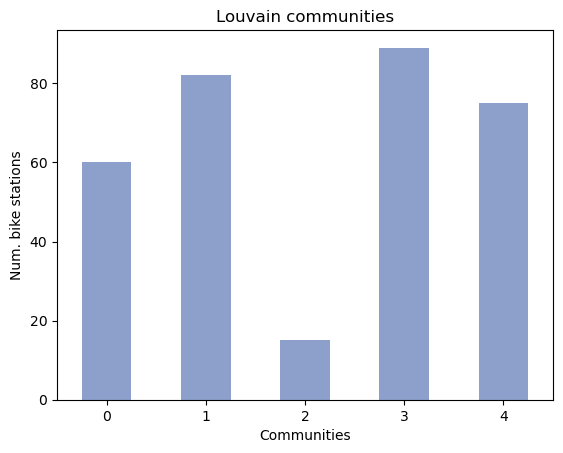

In [32]:
df_plm_communities.groupby('plm_communitie').count().reset_index().plot(x='plm_communitie', y='station_id', kind='bar', legend=False, color=BLUE)
plt.xlabel('Communities', rotation=0)
plt.xticks(rotation=0)
plt.ylabel('Num. bike stations')
plt.title('Louvain communities')
plt.show()


# Conclusion
Understanding the data is an important step for the business to gain insights into their operations and make data-driven decisions to achieve their business objectives. Data which requires geolocation often needs to be visualised in graphs to better understand how the nodes and edges are relative to and interact with one another.
For instance, in this tutorial, the business we were able to explore the trips and customers behaviour, and from there understand which are the more frequently bike stations. This was helpful in providing insights into the way Baywheels can manage their inventory.
The analysis done above happens on LynxKite which has just been made free and accessible for anyone to try! There are other tutorials available on their website which are easy to follow. As a drag and drop platform, the learning curve is gentle and easy to pick up. Save yourself precious time from writing code to plotting graphs when you can pull and have the platform do a variety of graphing analysis and visualisations for you! Check out our second article if you want to know how we put these analyses together on LynxKite.

The next part of the article will take a look at how machine learning methods can be applied to further enhance understanding of relationships within the network.

In this part of the article, the Helsinki city bike network was briefly analyzed as a complex network. Multiple centrality measures were applied to the network and important centres were identified. Tree community detection algorithms revealed different possible groupings of the nodes within the network. The next part of the article will take a look at how machine learning methods can be applied to further enhance understanding of relationships within the network.